# Regression of Used Car Prices

## Import library and read data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from scipy.stats import loguniform, uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/playground-series-s4e9/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sub_df = pd.read_csv(data_dir + 'sample_submission.csv')

original_data_dir = '/kaggle/input/used-car-price-prediction-dataset/'
original_df = pd.read_csv(original_data_dir + 'used_cars.csv')

In [3]:
raw_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
raw_df.isna().sum()

id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [5]:
def draw_numeric_features(data, x=None, y=None, overlap=None):
    plt.figure(figsize=(30,10))
    plt.grid()
    sns.lineplot(data, x=x, y=y)
    if overlap is not None:
        for plot in overlap:
            sns.lineplot(data=plot[0], x=plot[1], y=plot[2])

def view_avg_of_each(cat_features: str, target: str):
    d = dict()
    cols = raw_df[cat_features].unique()
    for x in cols:
        d[x] = raw_df[raw_df[cat_features]==x][target].mean()
    return pd.Series(d, index=cols)

In [6]:
raw_df['price'].describe()

count    1.885330e+05
mean     4.387802e+04
std      7.881952e+04
min      2.000000e+03
25%      1.700000e+04
50%      3.082500e+04
75%      4.990000e+04
max      2.954083e+06
Name: price, dtype: float64

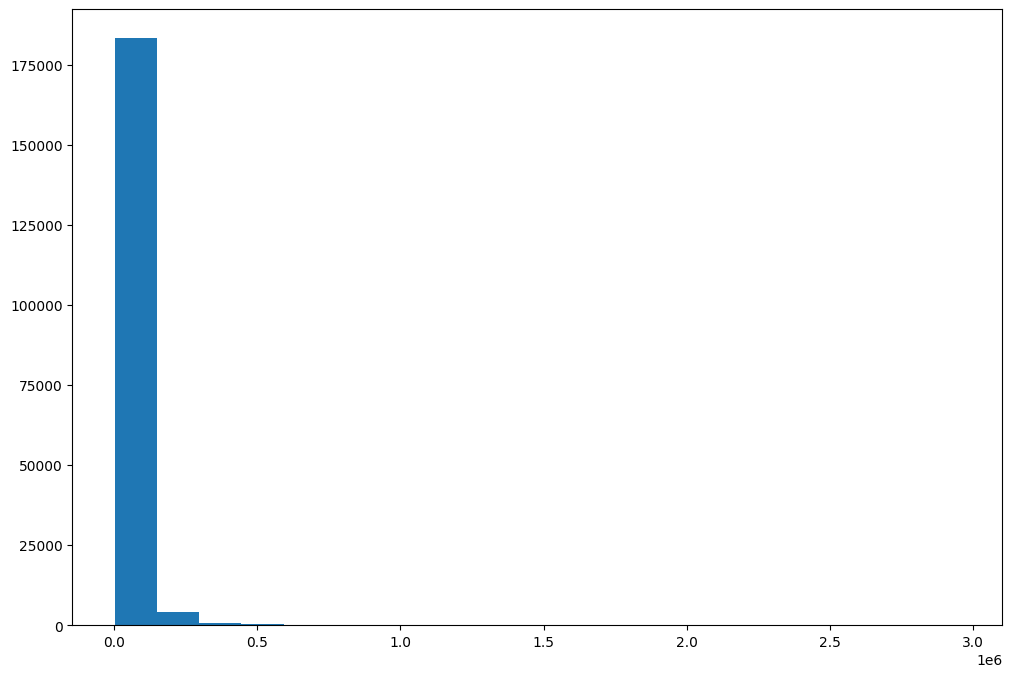

In [7]:
plt.figure(figsize=(12,8))
plt.hist(raw_df['price'], bins=20);

In [8]:
numeric_features = []
categorical_features = []
original_features = raw_df.columns.tolist()

## EDA & Feature Engineering

In [9]:
# Threshold to classify which values is noise
min_threshold = 100

### Brand

In [10]:
len(raw_df['brand'].unique())

57

In [11]:
categorical_features.append('brand')

### Model

In [12]:
len(raw_df['model'].unique())

1897

In [13]:
noise_model = raw_df['model'].value_counts(dropna=False)
noise_model = noise_model[noise_model<min_threshold]
len(noise_model)

1417

In [14]:
for df in [raw_df, test_df, original_df]:
    df['short_model'] = df['model'].apply(lambda x: str(x).split(' ')[0])
    df['model'] = df['model'].apply(lambda x: 'noise' if x in noise_model else x)

In [15]:
len(raw_df['short_model'].unique())

517

In [16]:
categorical_features += ['model', 'short_model']

### Model year

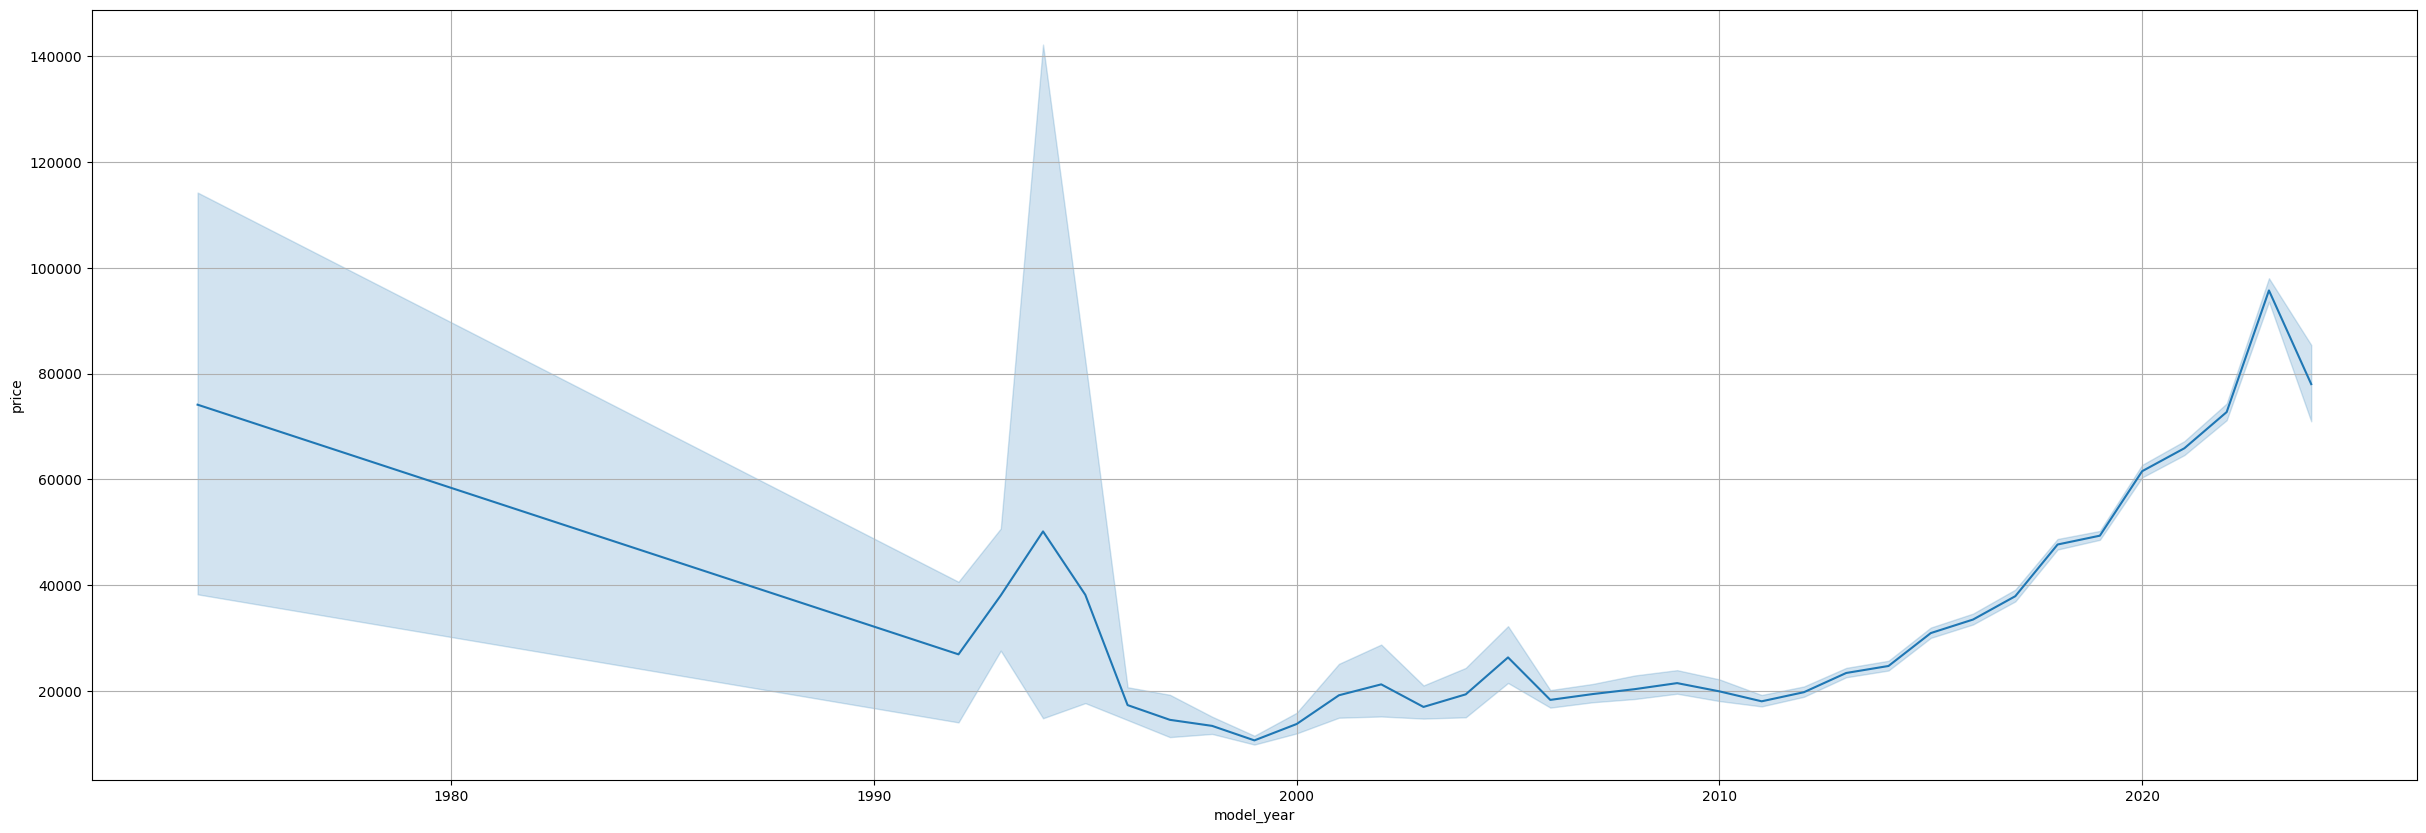

In [17]:
draw_numeric_features(data=raw_df, x='model_year', y='price')

In [18]:
def get_assessing_epreciation_percent(x):
    if x<1:
        return 7
    if x<=3:
        return 6.5 * x + 7
    if x<=7:
        return 6 * (x - 3) + 6.5 * 3 + 7
    if x<=10:
        return 8.5 * (x-7) + 6 * 4 + 6.5 * 3 + 7
    return 8.5 * 3 + 6 * 4 + 6.5 * 3 + 0.15 * (x-10) + 7

In [19]:
for df in [raw_df, test_df, original_df]:
    df['model_year'] = df['model_year'].apply(lambda x: 2024-x)
    df['assessing_epreciation_percent'] = df['model_year'].apply(lambda x: get_assessing_epreciation_percent(x))

In [20]:
raw_df['assessing_epreciation_percent'].describe()

count    188533.000000
mean         50.876764
std          21.983172
min           7.000000
25%          32.500000
50%          50.500000
75%          76.150000
max          82.000000
Name: assessing_epreciation_percent, dtype: float64

In [21]:
numeric_features += ['model_year','assessing_epreciation_percent']

### Mileage

In [22]:
def help_change_milage(x):
    milage_str = str(x).split(' ')[0]
    milage_lst = milage_str.split(',')
    if len(milage_lst) >= 2:
        return int(milage_lst[0]) * 1000 + int(milage_lst[1])
    return int(milage_lst[0])
original_df['milage'] = original_df['milage'].apply(lambda x: help_change_milage(x))

In [23]:
raw_df['milage'].describe()

count    188533.000000
mean      65705.295174
std       49798.158076
min         100.000000
25%       24115.000000
50%       57785.000000
75%       95400.000000
max      405000.000000
Name: milage, dtype: float64

In [24]:
for df in [raw_df, test_df, original_df]:
    df['milage_per_year'] = df['milage']/(df['model_year']+1)
    df['good_milage'] = df['milage_per_year'].apply(lambda x: 0 if x<12000 else 1)

In [25]:
raw_df['good_milage'].value_counts()

good_milage
0    167595
1     20938
Name: count, dtype: int64

In [26]:
view_avg_of_each('good_milage','price')

0    45160.392542
1    33613.431846
dtype: float64

In [27]:
numeric_features += ['milage','milage_per_year','good_milage']

### Fuel Type

In [28]:
raw_df['fuel_type'].value_counts(dropna=False)

fuel_type
Gasoline          165940
Hybrid              6832
E85 Flex Fuel       5406
NaN                 5083
Diesel              3955
–                    781
Plug-In Hybrid       521
not supported         15
Name: count, dtype: int64

In [29]:
for df in [raw_df, test_df, original_df]:
    df['fuel_type'] = df['fuel_type'].apply(lambda x: 'rem' if (x==np.nan or str(x)=='nan') else x)

In [30]:
view_avg_of_each('fuel_type', 'price')

Gasoline          43360.013782
E85 Flex Fuel     26729.755457
rem               60822.612040
Hybrid            55473.451698
Diesel            48769.587358
Plug-In Hybrid    44150.967370
–                 36414.285531
not supported     20692.733333
dtype: float64

In [31]:
categorical_features.append('fuel_type')

### Engine

In [32]:
raw_df['engine'].isna().sum()

0

In [33]:
len(raw_df['engine'].unique())

1117

In [34]:
def split_engine(x, need_find: str):
    result = {'horsepower': -1, 'litres': -1, 
              'num_cyl': -1, 'ver': -1,
              'vol': -1, 'type_cyl': 'unk', 'turbo': -1}
    x_lst = str(x).split(' ')
    for i in range(len(x_lst)):
        e = x_lst[i]
        if e.find('HP')>=0 and result['horsepower']==-1:
            result['horsepower'] = e.split('HP')[0]
        elif e.find('L')>0 and result['litres']==-1:
            result['litres'] = e.split('L')[0]
        elif e == 'Liter' and result['litres']==-1 and i>=1:
            result['litres'] = x_lst[i-1]
        elif e == 'Cylinder' and result['num_cyl']==-1 and i>=1:
            num = x_lst[i-1]
            if num.isnumeric():
                result['num_cyl'] = num
        elif e in ['V6','V8','V10','V12','V14'] and result['ver']==-1:
            result['ver'] = e.split('V')[1]
        elif e.find('V')>0 and result['vol'] == -1:
            num = e.split('V')[0]
            if num.isnumeric():
                result['vol'] = num
        elif e in ['SOHC', 'DOHC', 'OHV', 'Electric'] and result['type_cyl']=='unk':
            result['type_cyl'] = e
        elif e == 'Turbo' and result['turbo']==-1:
            result['turbo'] = 1
            if i>=1 and x_lst[i-1] == 'Twin':
                result['turbo'] = 2
        else:
            continue
    return result[need_find]

In [35]:
noise_engine = raw_df['engine'].value_counts(dropna=False)
noise_engine = noise_engine[noise_engine<min_threshold]
len(noise_engine)

711

In [36]:
for df in [raw_df, test_df, original_df]:
    df['horsepower'] = df['engine'].apply(lambda x: split_engine(x, 'horsepower'))
    df['horsepower'] = df['horsepower'].astype('float32')
    
    df['litres'] = df['engine'].apply(lambda x: split_engine(x, 'litres'))
    df['litres'] = df['litres'].astype('float32')
    
    df['num_cyl'] = df['engine'].apply(lambda x: split_engine(x, 'num_cyl'))
    df['num_cyl'] = df['num_cyl'].astype('int8')
    
    df['ver'] = df['engine'].apply(lambda x: split_engine(x, 'ver'))
    df['ver'] = df['ver'].astype('int8')

    df['vol'] = df['engine'].apply(lambda x: split_engine(x, 'vol'))
    df['vol'] = df['vol'].astype('int8')
    
    df['type_cyl'] = df['engine'].apply(lambda x: split_engine(x, 'type_cyl'))
    
    df['turbo'] = df['engine'].apply(lambda x: split_engine(x, 'turbo'))
    df['turbo'] = df['turbo'].astype('int8')

    df['engine'] = df['engine'].apply(lambda x: 'noise' if x in noise_engine else x)

In [37]:
for df in [raw_df, test_df, original_df]:
    df['turbo'] = df['turbo'].apply(lambda x: x if x>0 else 0)
    df['ver'] = df['ver'].apply(lambda x: x if x>0 else 0)
    for col in ['horsepower','litres']:
        avg = raw_df[raw_df[col]>=0][col].mean()
        df[col] = df[col].apply(lambda x: x if x>=0 else avg)
    for col in ['num_cyl','vol']:
        avg = raw_df[raw_df[col]>=0][col].mean().astype('int8')
        df[col] = df[col].apply(lambda x: x if x>=0 else avg)

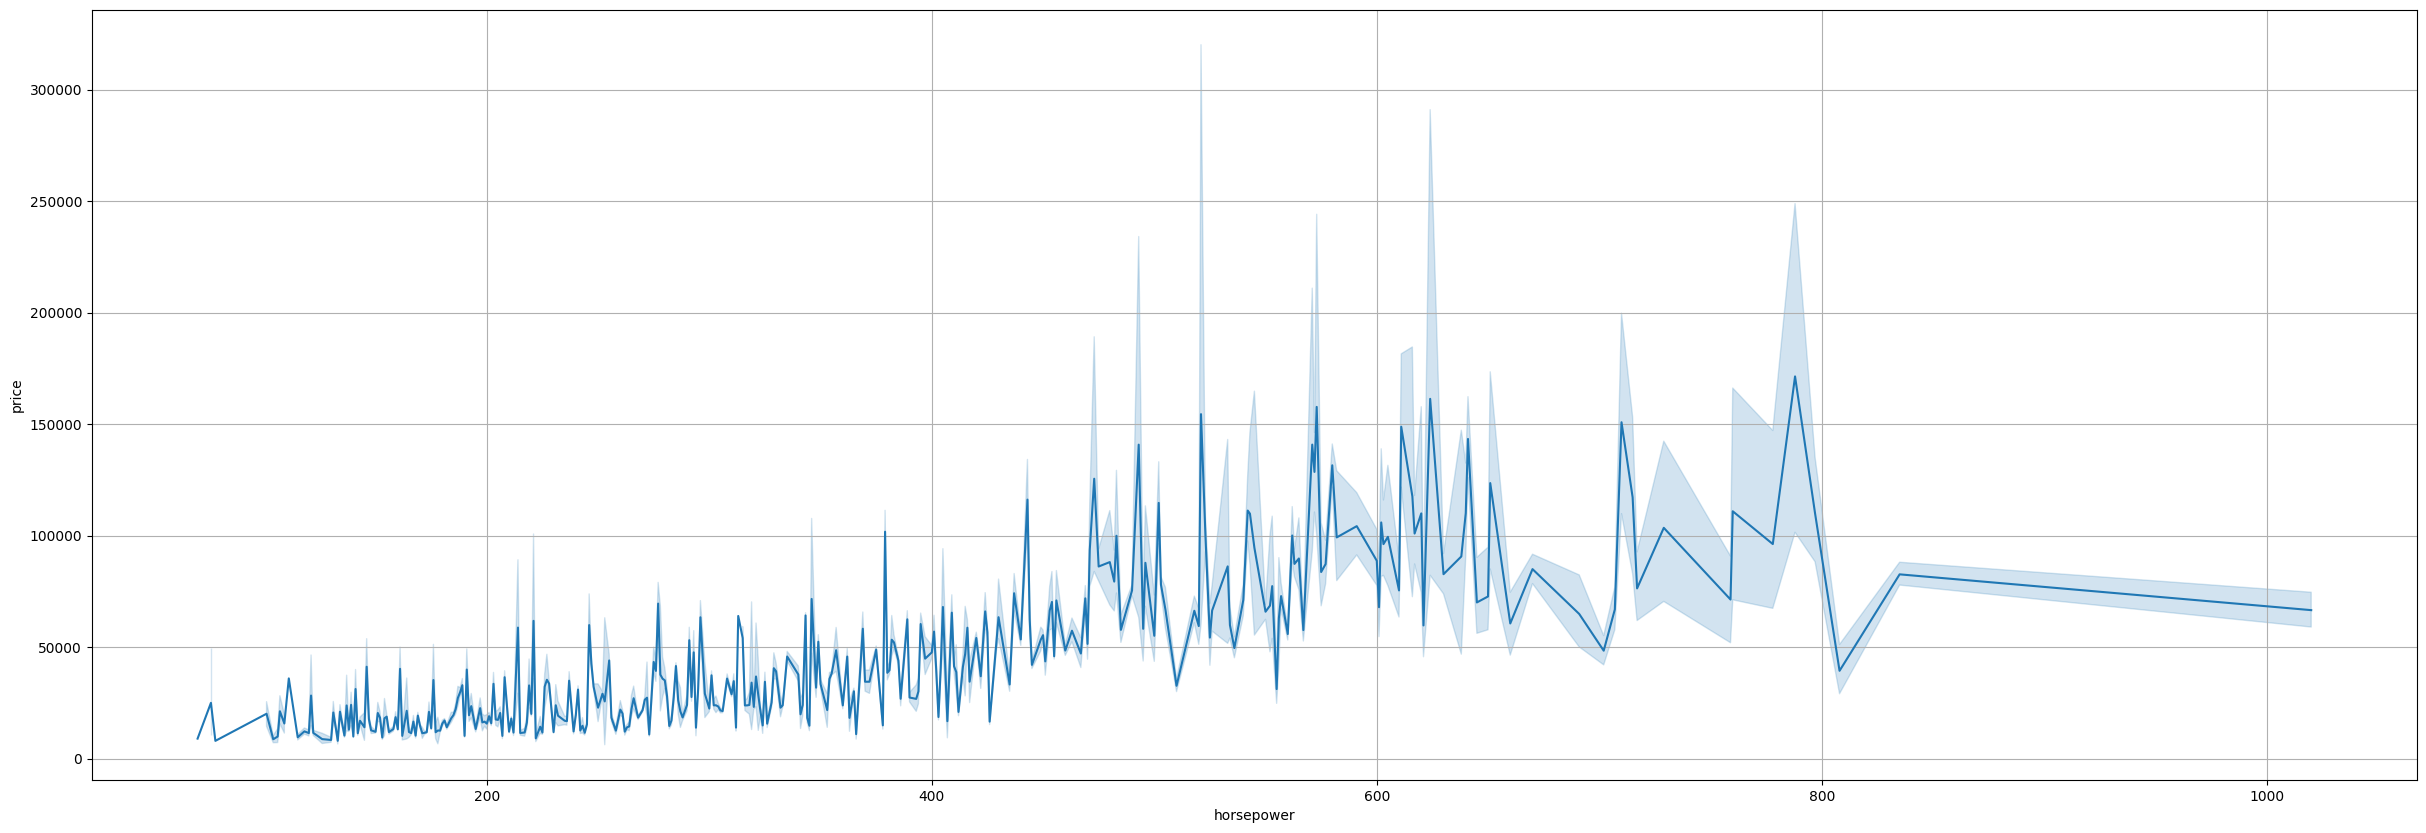

In [38]:
draw_numeric_features(raw_df, 'horsepower', 'price')

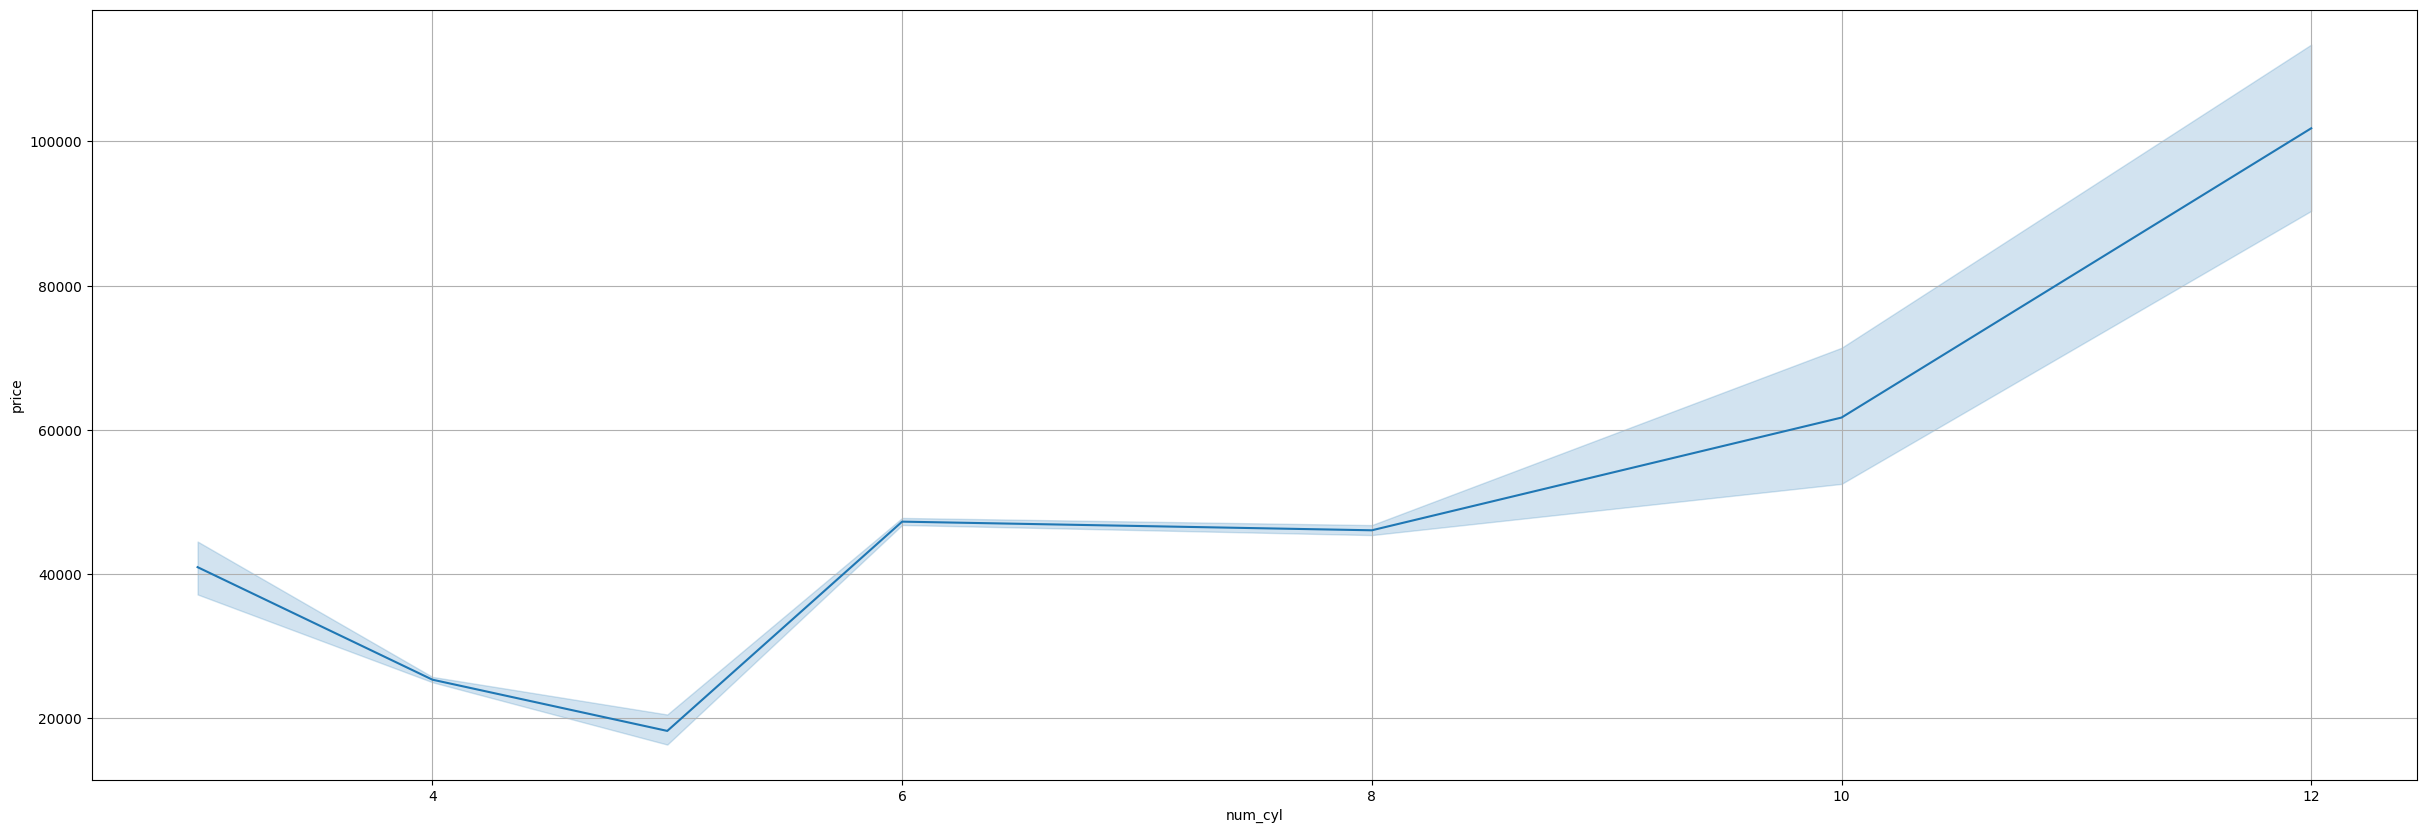

In [39]:
draw_numeric_features(raw_df, 'num_cyl', 'price')

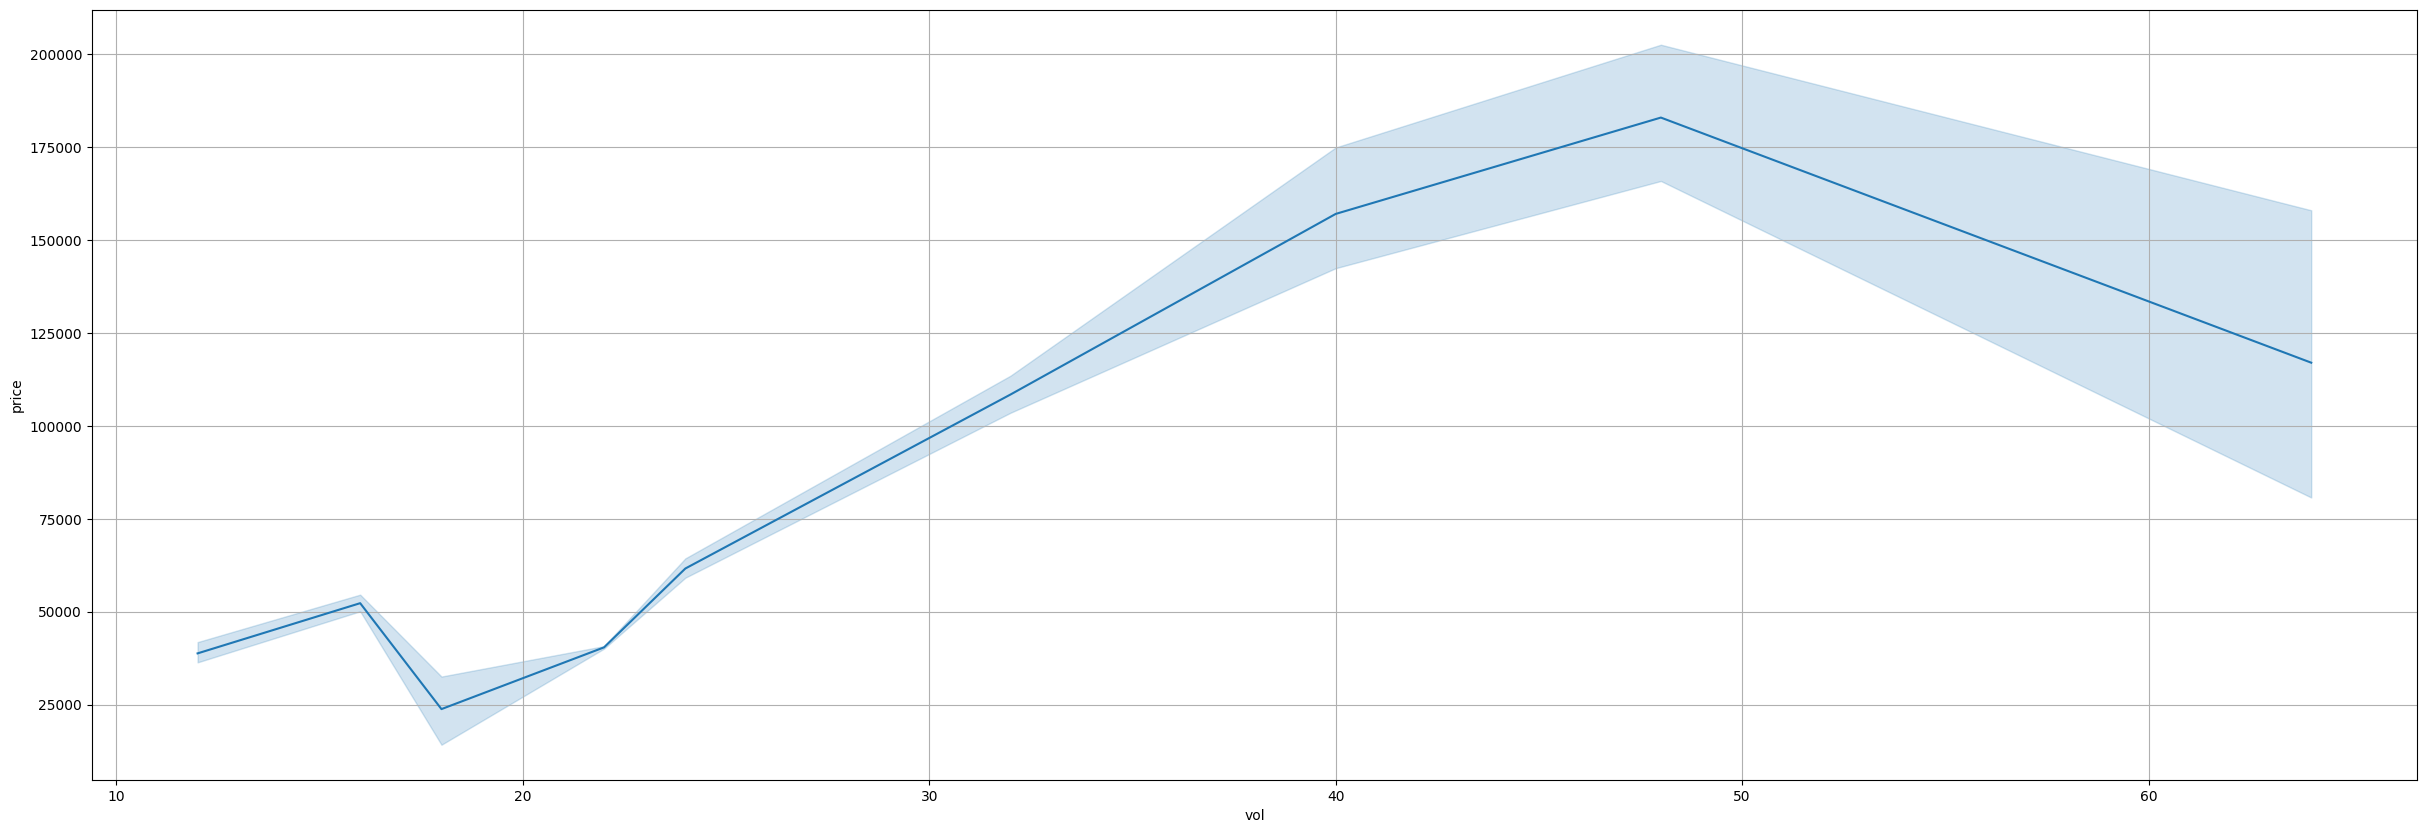

In [40]:
draw_numeric_features(raw_df, 'vol', 'price')

In [41]:
view_avg_of_each('ver','price')

0      44536.603343
6      35480.522828
10    157057.686375
8      88027.528370
12    173761.592593
dtype: float64

In [42]:
view_avg_of_each('turbo','price')

0    41760.937910
2    91263.592075
1    49775.101944
dtype: float64

In [43]:
view_avg_of_each('type_cyl','price')

unk         39026.610939
DOHC        68014.759650
Electric    62678.295223
OHV         70728.657875
SOHC        54658.378913
dtype: float64

In [44]:
len(raw_df[['horsepower','litres','num_cyl','ver','vol','type_cyl','turbo']].value_counts()), len(raw_df['engine'].value_counts())

(1007, 407)

In [45]:
numeric_features += ['horsepower','litres','num_cyl','ver','vol','turbo']
categorical_features += ['engine','type_cyl']

### Transmission

In [46]:
len(raw_df['transmission'].unique())

52

In [47]:
raw_df['transmission'] = raw_df['transmission'].apply(lambda x: str(x).lower())
raw_df['transmission']

0                                    a/t
1                                    a/t
2                                    a/t
3         transmission w/dual shift mode
4                            7-speed a/t
                       ...              
188528    transmission w/dual shift mode
188529                       8-speed a/t
188530                       7-speed a/t
188531                 1-speed automatic
188532    transmission w/dual shift mode
Name: transmission, Length: 188533, dtype: object

In [48]:
def split_transmission(x, need_find:str):
    result = {
        'trans_speed': -1,
        'trans_type': 'unk'
    }
    x_lst = str(x).split(' ')
    for i in range(len(x_lst)):
        e = x_lst[i]
        if e.find('-speed')>=0 and result['trans_speed'] == -1:
            val = e.split('-speed')[0]
            if val == 'single':
                val = 1
            result['trans_speed'] = val
        elif e == 'speed' and result['trans_speed'] == -1 and i>=1:
            val = x_lst[i-1]
            if val == 'single':
                val = 1
            result['trans_speed'] = val
        elif e in ['at','a/t','automatic'] and result['trans_type'] == 'unk':
            result['trans_type'] = 'a'
        elif e in ['mt','m/t','manual'] and result['trans_type'] == 'unk':
            result['trans_type'] = 'm'
        elif e == 'cvt' and result['trans_type'] == 'unk':
            result['trans_type'] = 'c'
        elif e == 'w/dual' and result['trans_type'] == 'unk':
            result['trans_type'] = 'w'
        else:
            continue
    return result[need_find]

In [49]:
noise_transmission = raw_df['transmission'].value_counts(dropna=False)
noise_transmission = noise_transmission[noise_transmission<min_threshold]
len(noise_transmission)

21

In [50]:
for df in [raw_df, test_df, original_df]:
    df['trans_speed'] = df['transmission'].apply(lambda x: split_transmission(x, 'trans_speed'))
    df['trans_speed'] = df['trans_speed'].astype('int8')
    df['trans_type'] = df['transmission'].apply(lambda x: split_transmission(x, 'trans_type'))

In [51]:
avg = raw_df[raw_df['trans_speed']>0]['trans_speed'].mean().astype('int8')
for df in [raw_df, test_df, original_df]:
    df['trans_speed'] = df['trans_speed'].apply(lambda x: x if x>=0 else avg)

In [52]:
categorical_features += ['transmission','trans_type']
numeric_features.append('trans_speed')

### Color

In [53]:
for df in [raw_df, test_df, original_df]:
    df['ext_col'] = df['ext_col'].apply(lambda x: str(x).lower())
    df['int_col'] = df['int_col'].apply(lambda x: str(x).lower())

In [54]:
# To view ext and int color
simple_cols = ['black','white','gray','silver','blue','red','green','gold',
               'brown','orange','beige','yellow','parchment']

In [55]:
def get_simple_col(x):
    x_lst = str(x).split(' ')
    for s in x_lst:
        if s in simple_cols: 
            return s
        for col in simple_cols:
            if s.find(col)>=0:
                return col
    return 'rem'

In [56]:
for df in [raw_df, test_df, original_df]:
    df['simple_ext_col'] = df['ext_col'].apply(lambda x: get_simple_col(x))
    df['simple_int_col'] = df['int_col'].apply(lambda x: get_simple_col(x))

In [57]:
noise_ext_col = raw_df['ext_col'].value_counts(dropna=False)
noise_ext_col = noise_ext_col[noise_ext_col<min_threshold]

noise_int_col = raw_df['int_col'].value_counts(dropna=False)
noise_int_col = noise_int_col[noise_int_col<min_threshold]

len(noise_ext_col), len(noise_int_col)

(257, 119)

In [58]:
for df in [raw_df, test_df, original_df]:
    df['ext_col'] = df['ext_col'].apply(lambda x: 'noise' if x in noise_ext_col else x)
    df['int_col'] = df['int_col'].apply(lambda x: 'noise' if x in noise_int_col else x)

In [59]:
categorical_features += ['ext_col','int_col','simple_ext_col','simple_int_col']

### Accident

In [60]:
raw_df['accident'].value_counts(dropna=False)

accident
None reported                             144514
At least 1 accident or damage reported     41567
NaN                                         2452
Name: count, dtype: int64

In [61]:
for df in [raw_df, test_df, original_df]:
    df['accident'] = df['accident'].apply(lambda x: 1 if x=='At least 1 accident or damage reported' else 0)

In [62]:
view_avg_of_each('accident','price')

0    49122.876550
1    25334.071475
dtype: float64

In [63]:
numeric_features.append('accident')

### Clean title

In [64]:
raw_df['clean_title'].value_counts(dropna=False)

clean_title
Yes    167114
NaN     21419
Name: count, dtype: int64

In [65]:
for df in [raw_df, test_df, original_df]:
    df['clean_title'] = df['clean_title'].apply(lambda x: 1 if x=='Yes' else 0)

In [66]:
view_avg_of_each('clean_title','price')

1    41354.406704
0    63567.566273
dtype: float64

In [67]:
numeric_features.append('clean_title')

In [68]:
len(numeric_features), len(categorical_features)

(14, 12)

In [69]:
categorical_features

['brand',
 'model',
 'short_model',
 'fuel_type',
 'engine',
 'type_cyl',
 'transmission',
 'trans_type',
 'ext_col',
 'int_col',
 'simple_ext_col',
 'simple_int_col']

### Interactive Features with Target

In [70]:
brand_model_price = raw_df.groupby(['brand','model'])['price'].mean()
fuel_engine_trans_price = raw_df.groupby(['fuel_type','type_cyl','trans_type'])['price'].mean()

In [71]:
for df in [raw_df, test_df, original_df]:
    df['brand_model_price'] = df.apply(lambda x: brand_model_price.get((x['brand'],
                                                                        x['model'])), 
                                       axis=1)
    df['fuel_engine_transmission_price'] = df.apply(lambda x: fuel_engine_trans_price.get((x['fuel_type'],
                                                                                           x['type_cyl'],
                                                                                           x['trans_type'])), 
                                                    axis=1)

In [72]:
avg_brand_model_price = raw_df['brand_model_price'].mean()
avg_fuel_engine_transmission_price = raw_df['fuel_engine_transmission_price'].mean()
test_df.fillna({'brand_model_price': avg_brand_model_price,
                'fuel_engine_transmission_price': avg_fuel_engine_transmission_price},
                inplace=True)
original_df.fillna({'brand_model_price': avg_brand_model_price,
                    'fuel_engine_transmission_price': avg_fuel_engine_transmission_price},
                    inplace=True)

In [73]:
numeric_features += ['brand_model_price',
                     'fuel_engine_transmission_price']

## Preprocessing

In [74]:
len(original_df)

4009

In [75]:
original_df['id'] = [i for i in range(314223,314223+4009)]
def help_change_price(x):
    milage_str = str(x).split('$')[1]
    milage_lst = milage_str.split(',')
    if len(milage_lst) >= 2:
        return int(milage_lst[0]) * 1000 + int(milage_lst[1])
    return int(milage_lst[0])
original_df['price'] = original_df['price'].apply(lambda x: help_change_price(x))

In [76]:
concat_cols = ['id'] + categorical_features + numeric_features

In [77]:
concat_df = pd.concat([raw_df[concat_cols], test_df[concat_cols], original_df[concat_cols]]).copy()
concat_df.head()

,id,brand,model,short_model,fuel_type,engine,type_cyl,transmission,trans_type,ext_col,...,litres,num_cyl,ver,vol,turbo,trans_speed,accident,clean_title,brand_model_price,fuel_engine_transmission_price
0,0,MINI,Cooper S Base,Cooper,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,unk,a/t,a,yellow,...,1.6,4,0,22,0,7,0,1,12778.315972,38749.421740
1,1,Lincoln,noise,LS,Gasoline,noise,unk,a/t,a,silver,...,3.9,8,0,22,0,7,1,1,27746.704156,38749.421740
2,2,Chevrolet,noise,Silverado,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,unk,a/t,a,blue,...,5.3,8,0,22,0,7,0,1,35853.372897,25099.102016
3,3,Genesis,noise,G90,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,unk,transmission w/dual shift mode,w,black,...,5.0,8,0,22,0,7,0,1,53186.033730,49938.540132
4,4,Mercedes-Benz,Metris Base,Metris,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,unk,7-speed a/t,a,black,...,2.0,4,0,22,0,7,0,1,64855.673077,38749.421740


In [78]:
encoder = OrdinalEncoder()
encoder.fit(concat_df[categorical_features])

OrdinalEncoder()

In [79]:
for df in [raw_df, test_df, original_df]:
    df[categorical_features] = encoder.transform(df[categorical_features])

In [80]:
all_features = numeric_features + categorical_features
len(all_features)

28

In [81]:
concat_df = pd.concat([raw_df, original_df]).copy()
concat_df = concat_df.reset_index(drop=True)

In [82]:
concat_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,...,ver,vol,type_cyl,turbo,trans_speed,trans_type,simple_ext_col,simple_int_col,brand_model_price,fuel_engine_transmission_price
0,0,31.0,138.0,17,213000,2.0,21.0,97.0,59.0,14.0,...,0,22,4.0,0,7,0.0,12.0,5.0,12778.315972,38749.421740
1,1,28.0,481.0,22,143250,2.0,434.0,97.0,51.0,0.0,...,0,22,4.0,0,7,0.0,10.0,0.0,27746.704156,38749.421740
2,2,9.0,481.0,22,136731,1.0,224.0,97.0,10.0,14.0,...,0,22,4.0,0,7,0.0,2.0,5.0,35853.372897,25099.102016
3,3,16.0,481.0,7,19500,2.0,321.0,108.0,5.0,1.0,...,0,22,4.0,0,7,4.0,1.0,1.0,53186.033730,49938.540132
4,4,36.0,293.0,3,7388,2.0,67.0,51.0,5.0,0.0,...,0,22,4.0,0,7,0.0,1.0,0.0,64855.673077,38749.421740


In [83]:
inputs, targets = concat_df[all_features], concat_df['price']

In [84]:
%%time
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

CPU times: user 1min 46s, sys: 474 ms, total: 1min 46s
Wall time: 1min 46s


,Numerical_Feature_MI
milage,0.700622
engine,0.589732
model_year,0.556075
assessing_epreciation_percent,0.554952
horsepower,0.541239
transmission,0.436167
brand_model_price,0.389633
short_model,0.299897
model,0.280765
fuel_engine_transmission_price,0.234032


In [85]:
original_features.remove('id')
original_features.remove('price')
original_features

['brand',
 'model',
 'model_year',
 'milage',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

I have chosen a list of features that I fill important

In [86]:
extraction_features = ['brand','model','model_year','assessing_epreciation_percent',
                       'milage','good_milage','fuel_type','horsepower','litres',
                       'ver','vol','num_cyl','type_cyl','turbo','trans_speed',
                       'trans_type','simple_ext_col','simple_int_col','accident','clean_title']
len(extraction_features)

20

In [87]:
len(all_features)

28

## Training model and tunning hyperparameters

In [88]:
inte_cols = ['brand','model','fuel_type','engine','transmission',
             'ext_col','int_col','short_model','type_cyl']
for col in inte_cols:
    raw_df[col] = raw_df[col].astype('int32')
    test_df[col] = test_df[col].astype('int32')
    original_df[col] = original_df[col].astype('int32')

In [89]:
def cross_validation(reg, cv, inputs, targets, test_inputs=None, need_print=False):
    train_losses = []
    val_losses = []
    if test_inputs is not None:
        test_preds = np.zeros(len(test_inputs))
    else:
        test_preds = np.zeros(len(inputs))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        reg.fit(X_train, y_train)

        train_pred = reg.predict(X_train)
        train_loss = np.sqrt(mean_squared_error(y_train, train_pred))
        train_losses.append(train_loss)
        val_pred = reg.predict(X_val)
        val_loss = np.sqrt(mean_squared_error(y_val, val_pred))
        val_losses.append(val_loss)

        if need_print:
            print(f'Fold {fold}: train_loss = {train_loss:.5f}, val_loss = {val_loss:.5f}')

        if test_inputs is not None:
            test_pred = reg.predict(test_inputs)
            test_preds += test_pred/cv.get_n_splits()

    m_train_loss = np.mean(train_losses)
    s_train_loss = np.std(train_losses)
    m_val_loss = np.mean(val_losses)
    s_val_loss = np.std(val_losses)
    
    msg = f'{m_val_loss:.7f} ± {s_val_loss:.7f}'
    
    if need_print:
        print(f'Train loss: {m_train_loss:.7f} ± {s_train_loss:.7f} | Val loss: {m_val_loss:.7f} ± {s_val_loss:.7f}')
    return test_preds, msg

In [90]:
def test_with_models(models: dict, features: dict, 
                     df: pd.DataFrame, target: str, cv):
    result = dict()
    result['Regressor'] = []
    for feature, _ in features.items():
        result[f'RMSE with {feature} features'] = []
    targets = df[target]
    for name, model in models.items():
        result['Regressor'].append(name)
        for f_name, feature in features.items():
            inputs = df[feature]
            _, msg = cross_validation(model, cv, 
                                      inputs, targets, 
                                      test_inputs=None, 
                                      need_print=False)
            result[f'RMSE with {f_name} features'].append(msg)
    
    return pd.DataFrame(result)

In [91]:
regressors = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_jobs=-1),
    'XGBRegressor': XGBRegressor(n_jobs=-1),
    'LGBMRegressor': LGBMRegressor(n_jobs=-1, verbose=0),
    'CatBoostRegressor': CatBoostRegressor(logging_level='Silent')
}
features = {
    'all': all_features,
    'original': original_features,
    'extraction': extraction_features
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [92]:
%%time
test_with_models(regressors, features, raw_df, 'price', cv)

CPU times: user 1h 9min 22s, sys: 51.5 s, total: 1h 10min 13s
Wall time: 19min 28s


,Regressor,RMSE with all features,RMSE with original features,RMSE with extraction features
0,LinearRegression,73329.9733852 ± 161.3133420,74957.1080142 ± 174.2834714,74123.9473804 ± 161.4219274
1,Ridge,73329.9729625 ± 161.3127762,74957.1079278 ± 174.2835769,74123.9470128 ± 161.4211963
2,DecisionTreeRegressor,112721.0122490 ± 3952.7216846,113703.5357879 ± 4380.7909664,109746.8779357 ± 4981.7594519
3,RandomForestRegressor,78136.9788859 ± 797.6101102,78108.8267005 ± 682.5623506,78439.0384466 ± 802.8524846
4,XGBRegressor,75743.7233536 ± 775.4875584,75082.1639632 ± 572.3848027,75366.0016374 ± 297.2434398
5,LGBMRegressor,73072.8444947 ± 212.4621118,73041.3727876 ± 191.1881200,72971.4040919 ± 232.0406854
6,CatBoostRegressor,74006.6433603 ± 499.6860227,73741.8550156 ± 259.2911015,74132.8158608 ± 708.9767923


So we choose 3 model to view with `concat_df`, are
1. Linear Regression
2. LGBM Regressor
3. CatBoostRegressor

In [93]:
regressors = {
    'LinearRegression': LinearRegression(),
    'LGBMRegressor': LGBMRegressor(n_jobs=-1, verbose=0),
    'CatBoostRegressor': CatBoostRegressor(logging_level='Silent')
}
features = {
    'all': all_features,
    'original': original_features,
    'extraction': extraction_features
}

In [94]:
%%time
result_df = test_with_models(regressors, features, concat_df, 'price', cv)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

CPU times: user 17min 20s, sys: 38.2 s, total: 17min 58s
Wall time: 5min 32s


In [95]:
result_df

,Regressor,RMSE with all features,RMSE with original features,RMSE with extraction features
0,LinearRegression,72743.6896922 ± 356.2313086,74439.2270847 ± 328.8157069,73565.0945628 ± 345.5178397
1,LGBMRegressor,72381.3961587 ± 323.9726146,72493.7491743 ± 407.0598564,72313.5986067 ± 410.7104274
2,CatBoostRegressor,73133.6616395 ± 464.2767884,73063.8179139 ± 98.9338232,73131.7423994 ± 610.1192293


So concat_df make high performance and we will optim with LinearRegression and LGBMRegressor.

In [96]:
# Save the LB score
score_dict = dict()
score_dict['Name'] = []
score_dict['Val_score'] = []

### Linear Regression

In [97]:
%%time
reg = LinearRegression()
inputs, targets = concat_df[all_features], concat_df['price']
test_inputs = test_df[all_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 72622.92350, val_loss = 73157.15081
Fold 1: train_loss = 72691.48262, val_loss = 72881.39760
Fold 2: train_loss = 72844.65085, val_loss = 72274.22257
Fold 3: train_loss = 72819.53933, val_loss = 72370.53377
Fold 4: train_loss = 72652.33319, val_loss = 73035.14371
Train loss: 72726.1858977 ± 89.5214707 | Val loss: 72743.6896922 ± 356.2313086
CPU times: user 3.71 s, sys: 747 ms, total: 4.46 s
Wall time: 1.62 s


In [98]:
score_dict['Name'].append('LinearRegression_AllFeatures')
score_dict['Val_score'].append('72743.6896922 ± 356.2313086')
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_linear_all.csv', index=None)
sub_df.head()

,id,price
0,188533,32937.107603
1,188534,72689.740029
2,188535,81778.315887
3,188536,37781.026519
4,188537,31689.939755


In [99]:
%%time
reg = LinearRegression()
inputs, targets = concat_df[extraction_features], concat_df['price']
test_inputs = test_df[extraction_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 73456.03255, val_loss = 73961.52885
Fold 1: train_loss = 73534.23753, val_loss = 73649.29236
Fold 2: train_loss = 73671.23405, val_loss = 73101.16412
Fold 3: train_loss = 73639.96936, val_loss = 73227.12840
Fold 4: train_loss = 73474.13223, val_loss = 73886.35909
Train loss: 73555.1211458 ± 86.5971173 | Val loss: 73565.0945628 ± 345.5178397
CPU times: user 3 s, sys: 711 ms, total: 3.71 s
Wall time: 1.31 s


In [100]:
score_dict['Name'].append('LinearRegression_ExtractionFeatures')
score_dict['Val_score'].append('73565.0945628 ± 345.5178397')
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_linear_extraction.csv', index=None)
sub_df.head()

,id,price
0,188533,17345.828388
1,188534,68900.140321
2,188535,83849.420874
3,188536,35235.954666
4,188537,36217.401259


In [101]:
%%time
reg = LinearRegression()
add_target_features = extraction_features + ['brand_model_price','fuel_engine_transmission_price']
inputs, targets = concat_df[add_target_features], concat_df['price']
test_inputs = test_df[add_target_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 72719.63571, val_loss = 73242.78637
Fold 1: train_loss = 72782.58558, val_loss = 72988.81681
Fold 2: train_loss = 72935.09466, val_loss = 72384.37911
Fold 3: train_loss = 72920.23010, val_loss = 72438.88424
Fold 4: train_loss = 72749.08424, val_loss = 73120.04340
Train loss: 72821.3260600 ± 89.2030695 | Val loss: 72834.9819857 ± 355.2931057
CPU times: user 3.17 s, sys: 811 ms, total: 3.98 s
Wall time: 1.41 s


In [102]:
score_dict['Name'].append('LinearRegression_AddTargetFeatures')
score_dict['Val_score'].append('72834.9819857 ± 355.2931057')
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_linear_extraction_add_target.csv', index=None)
sub_df.head()

,id,price
0,188533,34443.470427
1,188534,69650.147403
2,188535,86023.804591
3,188536,40971.439414
4,188537,32839.915753


### LGBM Regressor

In [103]:
param_dis = {
    'num_leaves': np.arange(35,300,7),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(90,341,40),
    'learning_rate': loguniform(0.001,0.2),
    'max_depth': np.arange(25,55,3),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(14,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [0]
}

In [104]:
'''%%time
# Search for extraction features
search = RandomizedSearchCV(LGBMRegressor(),
                            param_dis,
                            n_iter=120,
                            scoring='neg_root_mean_squared_error', cv=4,
                            refit=True, verbose=3)
inputs, targets = concat_df[extraction_features], concat_df['price']
test_inputs = test_df[extraction_features]
search.fit(inputs, targets)
'''

"%%time\n# Search for extraction features\nsearch = RandomizedSearchCV(LGBMRegressor(),\n                            param_dis,\n                            n_iter=120,\n                            scoring='neg_root_mean_squared_error', cv=4,\n                            refit=True, verbose=3)\ninputs, targets = concat_df[extraction_features], concat_df['price']\ntest_inputs = test_df[extraction_features]\nsearch.fit(inputs, targets)\n"

In [105]:
extraction_f_best_params = {
 'colsample_bytree': 0.275285620500767,
 'learning_rate': 0.01820360192457708,
 'max_depth': 46,
 'min_child_samples': 14,
 'min_child_weight': 0.06972746009532313,
 'min_split_gain': 0.0005670747320269855,
 'n_estimators': 210,
 'n_jobs': -1,
 'num_leaves': 252,
 'random_state': 42,
 'reg_alpha': 1.9464128909292344e-05,
 'reg_lambda': 3.1770454877179892,
 'subsample': 0.6172369358699256,
 'verbose': 0}
reg = LGBMRegressor(**extraction_f_best_params)

In [106]:
%%time
reg = LGBMRegressor(**extraction_f_best_params)
inputs, targets = concat_df[extraction_features], concat_df['price']
test_inputs = test_df[extraction_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 0: train_loss = 67270.73088, val_loss = 72647.66539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1: train_loss = 67076.82485, val_loss = 72449.84046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 2: train_loss = 67400.47361, val_loss = 71699.23950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3: train_loss = 67586.35663, val_loss = 71572.83501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4: train_loss = 6

In [107]:
score_dict['Name'].append('LGBMRegressor_ExtractionFeatures')
score_dict['Val_score'].append('72158.7716847 ± 435.5969091')
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm_extraction.csv', index=None)
sub_df.head()

,id,price
0,188533,19771.358717
1,188534,78824.976075
2,188535,54174.409237
3,188536,28810.193534
4,188537,30722.407573


In [108]:
%%time
# Use extraction features best params to predict original features
add_target_features = extraction_features + ['brand_model_price','fuel_engine_transmission_price']
reg = LGBMRegressor(**extraction_f_best_params)
inputs, targets = concat_df[add_target_features], concat_df['price']
test_inputs = test_df[add_target_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 0: train_loss = 66941.44139, val_loss = 72709.17333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 1: train_loss = 66873.67604, val_loss = 72336.82434
Fold 2: train_loss = 67127.01077, val_loss = 71767.96131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 3: train_loss = 67293.96574, val_loss = 71553.90751
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4: train_loss = 66928.29408, val_loss = 72306.94404
Train loss: 67032.8776050 ± 155.9945525 | Val loss: 72134.9621062 ± 417.6981488
CPU times: user 1min 22s, sys: 21.9 ms, total: 1min 22s
Wall time: 1min 22s


In [109]:
score_dict['Name'].append('LGBMRegressor_AddTargetFeatures')
score_dict['Val_score'].append('72134.9621062 ± 417.6981488')
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm_extraction_add_target.csv', index=None)
sub_df.head()

,id,price
0,188533,22705.024797
1,188534,82695.713244
2,188535,58282.461082
3,188536,30436.569478
4,188537,29082.212292


In [110]:
'''%%time
# Search for original features
search = RandomizedSearchCV(LGBMRegressor(),
                            param_dis,
                            n_iter=120,
                            scoring='neg_root_mean_squared_error', cv=4,
                            refit=True, verbose=3)
inputs, targets = concat_df[original_features], concat_df['price']
test_inputs = test_df[original_features]
search.fit(inputs, targets)
'''

"%%time\n# Search for original features\nsearch = RandomizedSearchCV(LGBMRegressor(),\n                            param_dis,\n                            n_iter=120,\n                            scoring='neg_root_mean_squared_error', cv=4,\n                            refit=True, verbose=3)\ninputs, targets = concat_df[original_features], concat_df['price']\ntest_inputs = test_df[original_features]\nsearch.fit(inputs, targets)\n"

In [111]:
ori_f_best_params = {
 'colsample_bytree': 0.45652518143960086,
 'learning_rate': 0.013537421291420057,
 'max_depth': 40,
 'min_child_samples': 22,
 'min_child_weight': 0.000984327704047003,
 'min_split_gain': 4.9707874281395324e-05,
 'n_estimators': 250,
 'n_jobs': -1,
 'num_leaves': 224,
 'random_state': 42,
 'reg_alpha': 1.677228327772117e-05,
 'reg_lambda': 2.053807933204716,
 'subsample': 0.34136734743287284,
 'verbose': 0}
reg = LGBMRegressor(**ori_f_best_params)

In [112]:
%%time
inputs, targets = concat_df[original_features], concat_df['price']
test_inputs = test_df[original_features]
test_preds, _ = cross_validation(reg, cv, inputs, targets, test_inputs, need_print=True)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 0: train_loss = 67983.98747, val_loss = 72767.69019
Fold 1: train_loss = 67926.24492, val_loss = 72488.84067
Fold 2: train_loss = 68188.67318, val_loss = 71824.10760
Fold 3: train_loss = 68253.56879, val_loss = 71712.96483
Fold 4: train_loss = 67909.58079, val_loss = 72481.39818
Train loss: 68052.4110319 ± 141.4439570 | Val loss: 72255.0002928 ± 411.8881438
CPU times: user 1min 23s, sys: 16.8 ms, total: 1min 23s
Wall time: 1min 23s


In [113]:
score_dict['Name'].append('LGBMRegressor_OriginalFeatures')
score_dict['Val_score'].append('72255.0002928 ± 411.8881438')
sub_df['price'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm_ori.csv', index=None)
sub_df.head()

,id,price
0,188533,18102.441036
1,188534,78633.490816
2,188535,50700.008668
3,188536,29010.028684
4,188537,30676.303742


### View LB Score after submissions

In [114]:
pd.DataFrame(score_dict)

,Name,Val_score
0,LinearRegression_AllFeatures,72743.6896922 ± 356.2313086
1,LinearRegression_ExtractionFeatures,73565.0945628 ± 345.5178397
2,LinearRegression_AddTargetFeatures,72834.9819857 ± 355.2931057
3,LGBMRegressor_ExtractionFeatures,72158.7716847 ± 435.5969091
4,LGBMRegressor_AddTargetFeatures,72134.9621062 ± 417.6981488
5,LGBMRegressor_OriginalFeatures,72255.0002928 ± 411.8881438


So, I try with LGBM Regressor with extraction, add_target, original features and receive 72276.25050, 72471.35091, 72422.96599 in LB, in this order. 
Thus, adding target features helps reduce val loss but increases test loss.

In [115]:
sub_df = pd.read_csv('/kaggle/working/sub_lgbm_extraction.csv')
sub_df.head()

,id,price
0,188533,19771.358717
1,188534,78824.976075
2,188535,54174.409237
3,188536,28810.193534
4,188537,30722.407573


In [116]:
sub_df.to_csv('/kaggle/working/submission.csv', index=None)
sub_df.head()

,id,price
0,188533,19771.358717
1,188534,78824.976075
2,188535,54174.409237
3,188536,28810.193534
4,188537,30722.407573
